In [258]:
#!/usr/bin/env python3
import seaborn as sns
import concurrent.futures
import argparse
import numpy as np
import subprocess
import os
from pathlib import Path
from typing import List, Optional
import json
import pandas as pd


problems = ['toy', 'biased_mnist']
indep_measures = ['hsic', 'cka']
lambdas = [
    0,
    1 / 16,
    1 / 8,
    1 / 4,
    1 / 2,
    1,
    2,
    4,
    16,
    64,
    256,
    1024,
    4096,
    8192,
    16348,
    32768,
    65536,
]

kernels = ["linear", "rbf"]
runs = 10

stats = {prob: {indep: {k: {l: {} for l in lambdas} for k in kernels} for indep in indep_measures} for prob in problems}
for prob in problems:
    for indep in indep_measures:
        for k in kernels:
            root = Path(f"{prob}/{indep}/{k}_kernel")
            for l in lambdas:
                results_per_run = []
                for r in range(runs):
                    results = root / f"lambda_{l}" / f"run_{r}" / "results.json"
                    assert results.exists(), f'expected to find {results}!'

                    with open(results, "r") as f:
                        r = json.load(f)
                        results_per_run.append(r)

                cos = []
                norms = []
           

                for res in results_per_run:
                    if prob == 'toy':
                        net_0 = np.asarray(res["weights"]["0"]['dense/kernel:0'])
                        net_1 = np.asarray(res["weights"]["1"]['dense_2/kernel:0'])

                        norm_0 = float(np.sqrt(net_0.T @ net_0))
                        norm_1 = float(np.sqrt(net_1.T @ net_1))

                        c = (net_0.T @ net_1) / (norm_0 * norm_1)
                        assert -1 <= c and c <= 1
                        cos.append(float(c))
                        norms.append([norm_0, norm_1])
                    else:
                        w0 = np.asarray(res['weights']['0']['dense/kernel:0'])
                        w1 = np.asarray(res['weights']['1']['dense_2/kernel:0'])

                        norm_0 = float(np.linalg.norm(w0)) 
                        norm_1 = float(np.linalg.norm(w1))
                        norms.append([norm_0, norm_1])
                        
                        w0_normed = w0.T / np.linalg.norm(w0, axis=0)[:, np.newaxis]
                        w1_normed = w1.T / np.linalg.norm(w1, axis=0)[:, np.newaxis]
                         
                        c = w0_normed @ w1_normed.T
                        assert (np.absolute(c) <= 1).all()
                        cos.append(c)

                cur_stats = stats[prob][indep][k][l]
                cur_stats["cos"] = np.asarray(cos)
                cur_stats["norms"] = np.asarray(norms)
            
                for m in ['test_diversity_loss', 
                          'test_prediction_loss',
                          'train_diversity_loss',
                          'train_accuracy',
                          'test_accuracy'
                         ]:
                    cur_stats[m] = np.asarray([r[m] for r in results_per_run])

print('done')

done


In [265]:
def data_for_kernel(problem: str, indep: str, k: str, column: str, swap_by_column: Optional[str] = None) -> pd.DataFrame:
    data = []
    for l in lambdas:
        col = stats[problem][indep][k][l][column]

        if swap_by_column:
            swap_networks = [r[0] < r[1] for r in stats[problem][indep][k][l][swap_by_column]]
        else:
            swap_networks = [False] * len(col)
        
        for i_run, run_value in enumerate(col):
            if run_value.shape != ():
                if swap_networks[i_run]:
                    run_value = np.flip(run_value)
                
                for ix, d in enumerate(run_value):
                    data.append({
                        'lambda': l,
                        column: d,
                        'network': ix
                    })
            else:
                data.append({
                    'lambda': l,
                    column: run_value,
                })

    return pd.DataFrame(data=data)

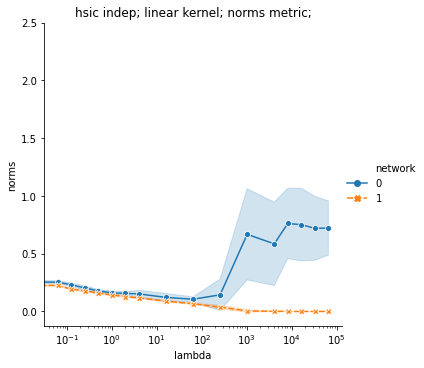

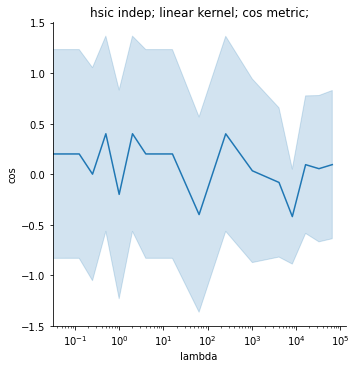

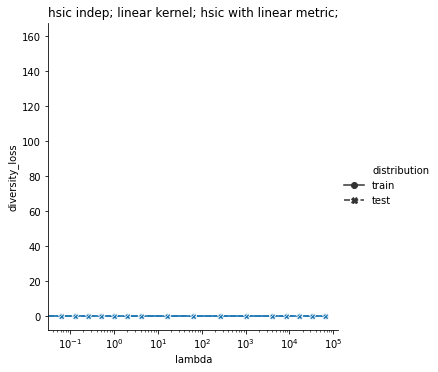

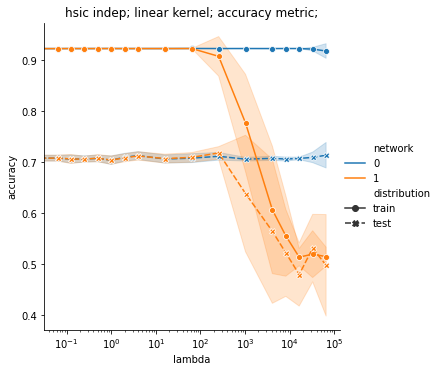

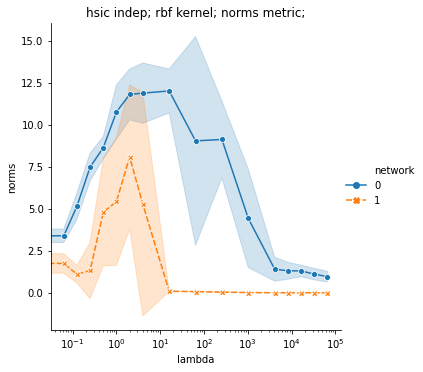

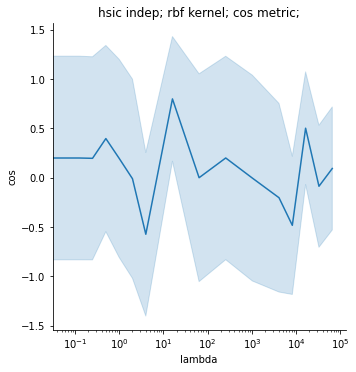

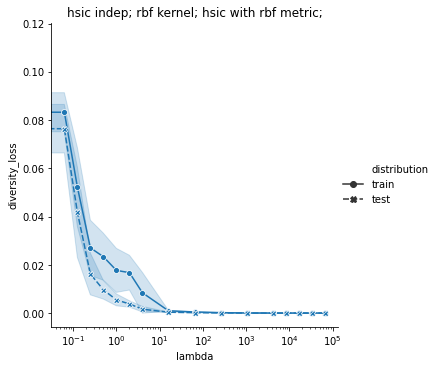

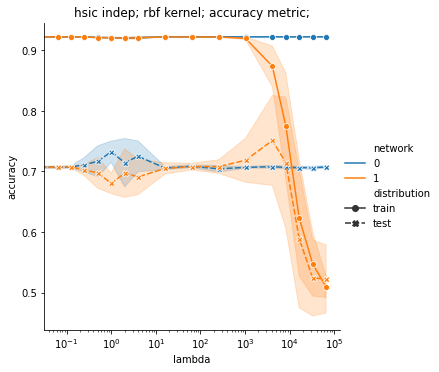

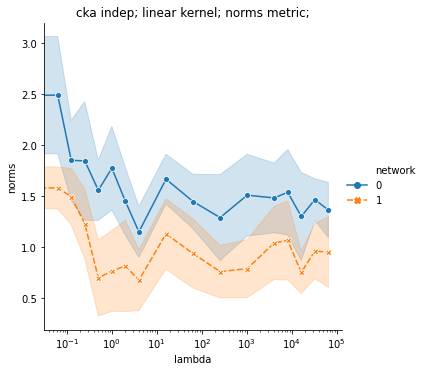

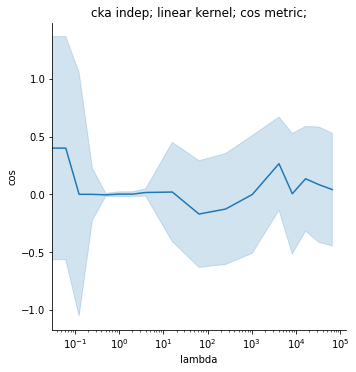

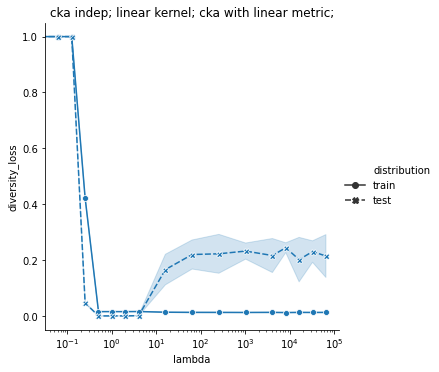

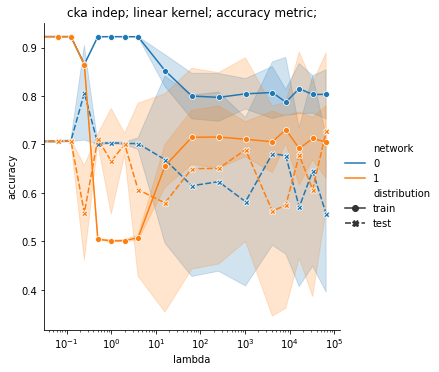

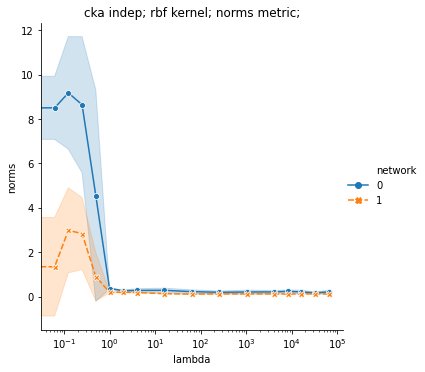

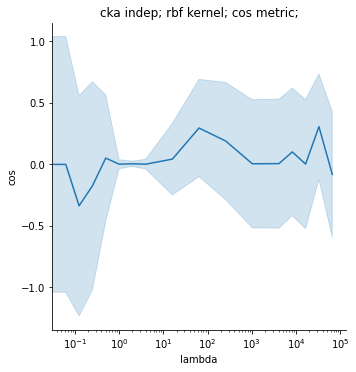

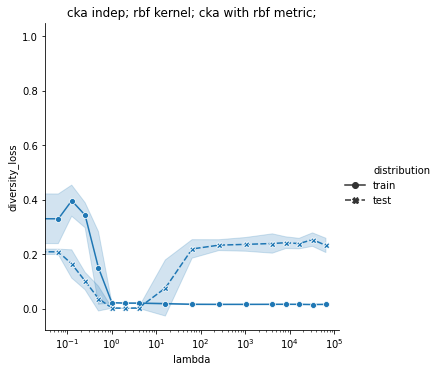

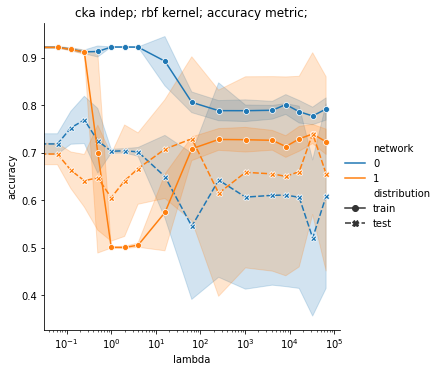

In [273]:
problem = 'toy'

for indep in indep_measures: 
    for k in kernels:
        for metric in ['norms', 'cos']:
            df = data_for_kernel(problem, indep, k, metric, swap_by_column='norms') 
            
            if 'network' in df:
                hue = 'network'
            else:
                hue = None
            plot = sns.relplot(x="lambda", y=metric, ci="sd", kind="line", hue=hue, style=hue, markers=True, data=df)
            plot.set(xscale="log")
            plot.set(title=f'{indep} indep; {k} kernel; {metric} metric;')
            os.makedirs(f'{problem}/plots', exist_ok=True)
            plot.savefig(f'{problem}/plots/{indep}_{k}_{metric}.png')
        
        
        
        df_train = data_for_kernel(problem, indep, k, 'train_diversity_loss', swap_by_column='norms').rename(columns={'train_diversity_loss': "diversity_loss"})
        df_train['distribution'] = 'train'
        df_test = data_for_kernel(problem, indep, k, 'test_diversity_loss', swap_by_column='norms').rename(columns={'test_diversity_loss': f"diversity_loss"})
        df_test['distribution'] = 'test'
        df = pd.concat([df_train, df_test])
        plot = sns.relplot(x="lambda", y='diversity_loss', ci="sd", kind="line", style='distribution', markers=True, data=df)
        plot.set(xscale="log")
        plot.set(title=f'{indep} indep; {k} kernel; {indep} with {k} metric;')
        os.makedirs(f'{problem}/plots', exist_ok=True)
        plot.savefig(f'{problem}/plots/{indep}_{k}_accuracy.png') 
        
        
        
        df_train = data_for_kernel(problem, indep, k, 'train_accuracy', swap_by_column='train_accuracy').rename(columns={'train_accuracy': 'accuracy'})
        df_train['distribution'] = 'train'
        df_test = data_for_kernel(problem, indep, k, 'test_accuracy', swap_by_column='train_accuracy').rename(columns={'test_accuracy': 'accuracy'})
        df_test['distribution'] = 'test'
        df = pd.concat([df_train, df_test])
        plot = sns.relplot(x="lambda", y='accuracy', ci="sd", kind="line", hue='network', style='distribution', markers=True, data=df)
        plot.set(xscale="log")
        plot.set(title=f'{indep} indep; {k} kernel; accuracy metric;')
        os.makedirs(f'{problem}/plots', exist_ok=True)
        plot.savefig(f'{problem}/plots/{indep}_{k}_accuracy.png') 

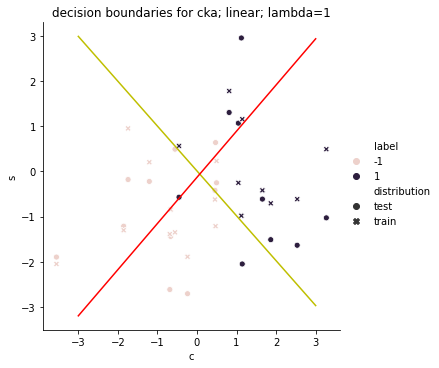

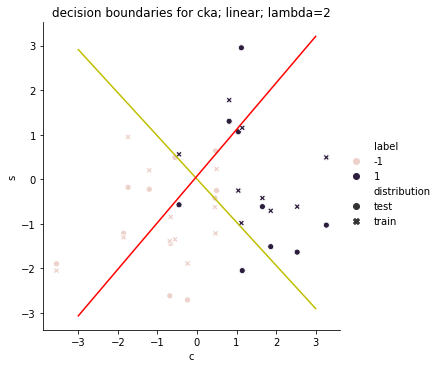

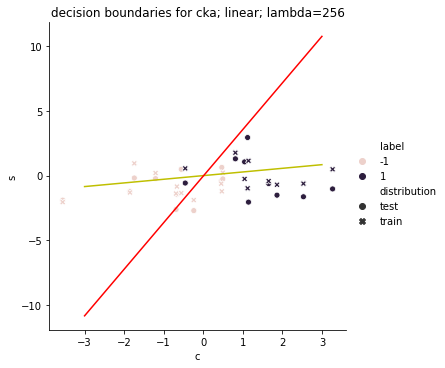

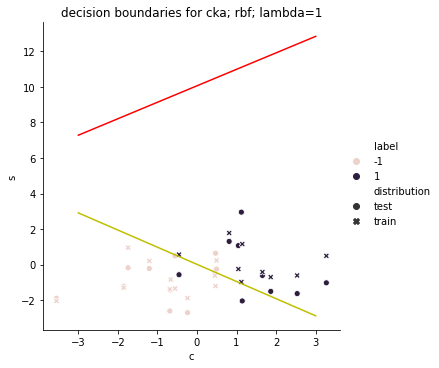

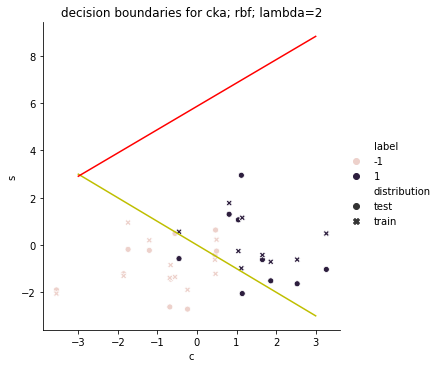

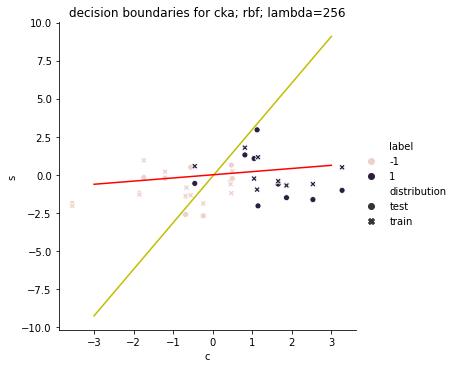

In [261]:
#!/usr/bin/env python3
import seaborn as sns
import concurrent.futures
import argparse
import numpy as np
import subprocess
import os
from pathlib import Path
from typing import List, Optional
import json
import pandas as pd
import matplotlib.pyplot as plt

n_samples = 20

sigma_c = 1.0
sigma_s = 1.0

np.random.seed(0)
y = np.random.choice([1, -1], size=(n_samples))
c = np.random.normal(y, scale=sigma_c, size=(n_samples))
z = np.random.choice([1, -1], size=(n_samples))
s = np.random.normal(z, scale=sigma_s, size=(n_samples))
data = []
for (x_0, x_1, c_y) in zip(c, s, y):
    data.append({
        'c': x_0,
        's': x_1,
        'label': c_y
    })
test_data = pd.DataFrame(data)
test_data['distribution'] = 'test'


np.random.seed(0)
y = np.random.choice([1, -1], size=(n_samples))
c = np.random.normal(y, scale=sigma_c, size=(n_samples))
s = np.random.normal(y, scale=sigma_s, size=(n_samples))
data = []
for (x_0, x_1, c_y) in zip(c, s, y):
    data.append({
        'c': x_0,
        's': x_1,
        'label': c_y
    })
train_data = pd.DataFrame(data)
train_data['distribution'] = 'train'

data = pd.concat([test_data, train_data])
    
xs = np.linspace(-3, 3)



params = []

for l in [1, 2, 256]:
    params.append(('cka', 'linear', l))
    
for l in [1, 2, 256]:
    params.append(('cka', 'rbf', l))


def eval_linear_function(a: float, b: float, c: float) -> np.ndarray:
    return - 1 / b * (a * xs + c) 


prob = 'toy'
for indep, k, l in params:
        root = Path(f"{prob}/{indep}/{k}_kernel")
        results = root / f"lambda_{l}" / f"run_1" / "results.json"
        assert results.exists(), f'expected to find {results}!'

        with open(results, "r") as f:
            res = json.load(f)

        net_0 = np.asarray(res["weights"]["0"]['dense/kernel:0'])
        net_0 = net_0 * res["weights"]["0"]["dense_1/kernel:0"][0][0]

        net_1 = np.asarray(res["weights"]["1"]['dense_2/kernel:0'])
        net_1 = net_1 * res["weights"]["1"]["dense_3/kernel:0"][0][0]

        ys_0 = eval_linear_function(a=net_0[0][0], b=net_0[1][0], c=res["weights"]["0"]["dense_1/bias:0"])
        ys_1 = eval_linear_function(a=net_1[0][0], b=net_1[1][0], c=res["weights"]["1"]["dense_3/bias:0"])

        sel_0 = np.absolute(ys_0) < 105.5
        sel_1 = np.absolute(ys_1) < 105.5

        plot = sns.relplot(x='c', y='s', hue='label', style='distribution', legend='full', data=data)
        plt.plot(xs[sel_0], ys_0[sel_0], 'y-')
        plt.plot(xs[sel_1], ys_1[sel_1], 'r-')
        plot.set(title=f"decision boundaries for {indep}; {k}; lambda={l}")

        plot.savefig(f'decision_boundaries_{indep}_{k}_lambda{l}.png')

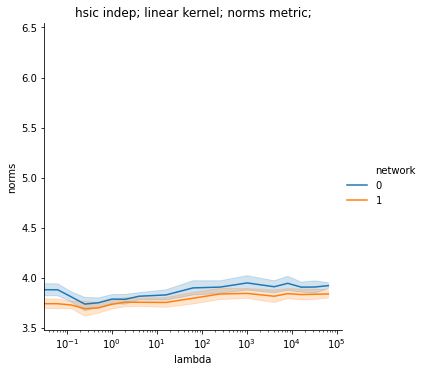

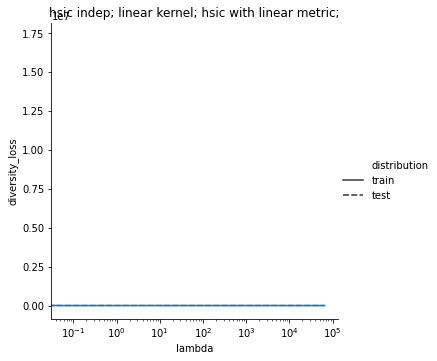

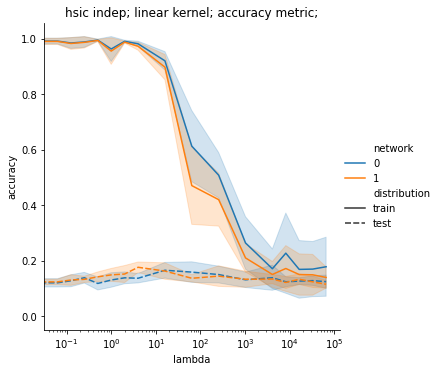

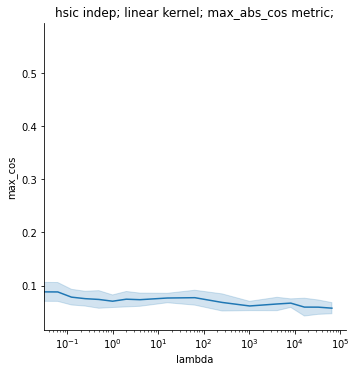

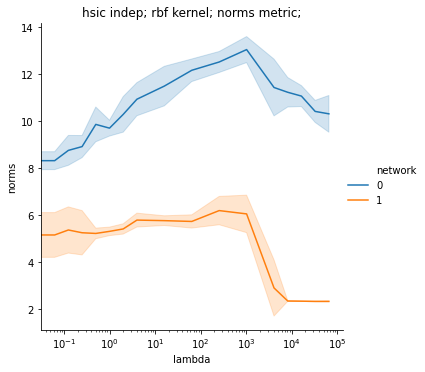

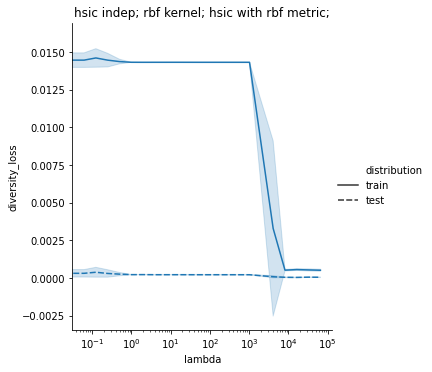

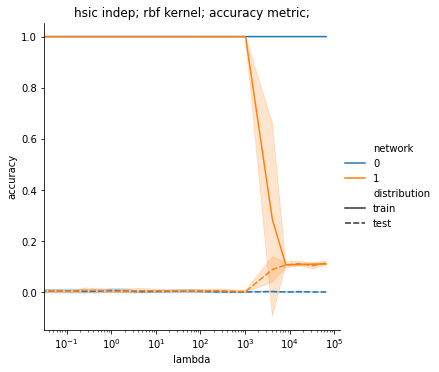

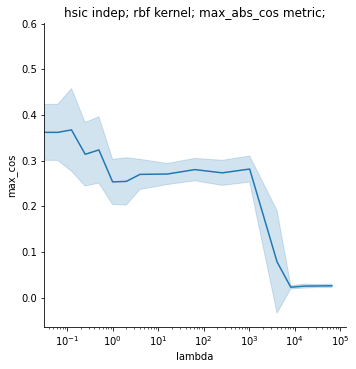

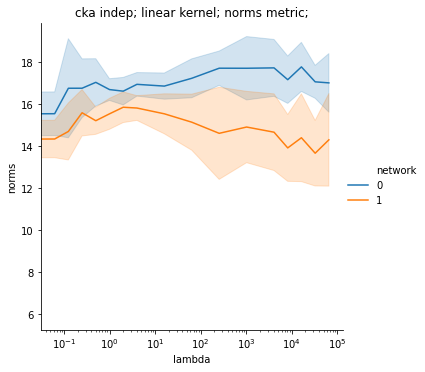

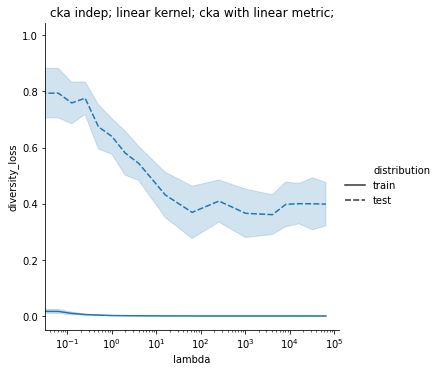

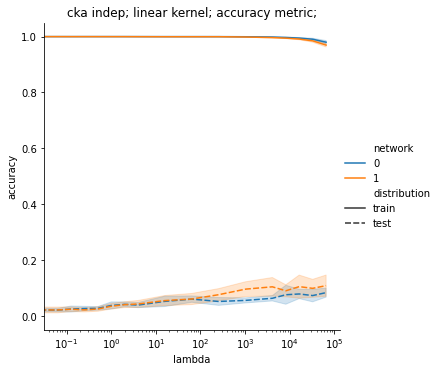

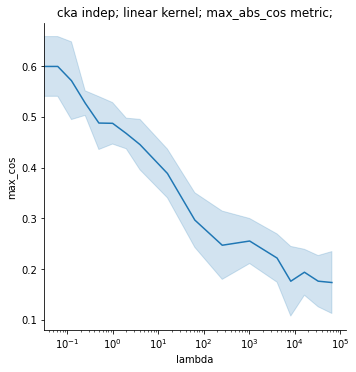

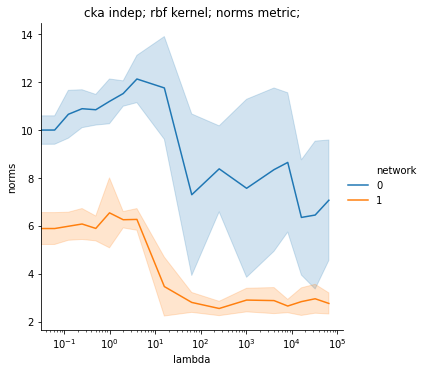

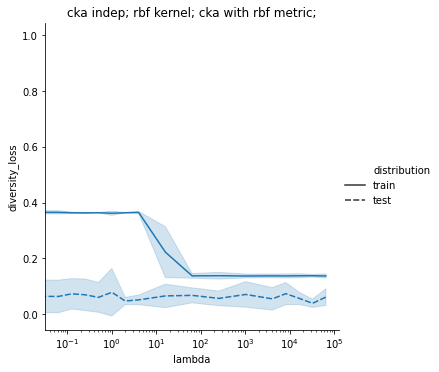

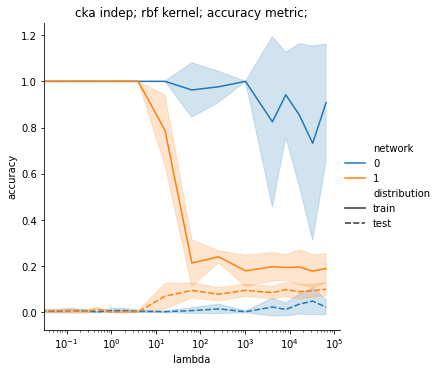

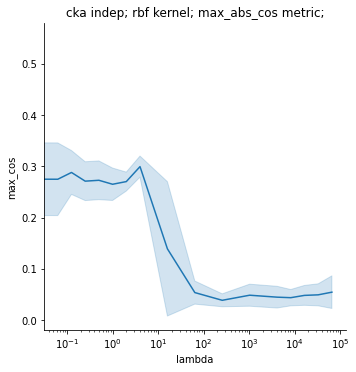

In [262]:
problem = 'biased_mnist'

for indep in indep_measures: 
    for k in kernels:
        for metric in ['norms']:
            df = data_for_kernel(problem, indep, k, metric, swap_by_column='norms') 
            
            if 'network' in df:
                hue = 'network'
            else:
                hue = None
            plot = sns.relplot(x="lambda", y=metric, ci="sd", kind="line", hue=hue, data=df)
            plot.set(xscale="log")
            plot.set(title=f'{indep} indep; {k} kernel; {metric} metric;')
            os.makedirs(f'{problem}/plots', exist_ok=True)
            plot.savefig(f'{problem}/plots/{indep}_{k}_{metric}.png')
        
        
        
        df_train = data_for_kernel(problem, indep, k, 'train_diversity_loss', swap_by_column='norms').rename(columns={'train_diversity_loss': "diversity_loss"})
        df_train['distribution'] = 'train'
        df_test = data_for_kernel(problem, indep, k, 'test_diversity_loss', swap_by_column='norms').rename(columns={'test_diversity_loss': f"diversity_loss"})
        df_test['distribution'] = 'test'
        df = pd.concat([df_train, df_test])
        plot = sns.relplot(x="lambda", y='diversity_loss', ci="sd", kind="line", style='distribution', data=df)
        plot.set(xscale="log")
        plot.set(title=f'{indep} indep; {k} kernel; {indep} with {k} metric;')
        os.makedirs(f'{problem}/plots', exist_ok=True)
        plot.savefig(f'{problem}/plots/{indep}_{k}_accuracy.png') 
        
        
        df_train = data_for_kernel(problem, indep, k, 'train_accuracy', swap_by_column='train_accuracy').rename(columns={'train_accuracy': 'accuracy'})
        df_train['distribution'] = 'train'
        df_test = data_for_kernel(problem, indep, k, 'test_accuracy', swap_by_column='train_accuracy').rename(columns={'test_accuracy': 'accuracy'})
        df_test['distribution'] = 'test'
        df = pd.concat([df_train, df_test])
        plot = sns.relplot(x="lambda", y='accuracy', ci="sd", kind="line", hue='network', style='distribution', data=df)
        plot.set(xscale="log")
        plot.set(title=f'{indep} indep; {k} kernel; accuracy metric;')
        os.makedirs(f'{problem}/plots', exist_ok=True)
        plot.savefig(f'{problem}/plots/{indep}_{k}_accuracy.png')
        
        data = []
        for l in lambdas:
            col = stats[problem][indep][k][l]['cos']
            col = np.absolute(col).max(axis=(1, 2))
            
            for ir, x in enumerate(col):
                data.append({
                    'lambda': l,
                    'max_cos': x,
                    'run': ir,
                })
        df = pd.DataFrame(data)
        plot = sns.relplot(x='lambda', y='max_cos', ci='sd', kind='line', data=df)
        plot.set(xscale="log")
        plot.set(title=f"{indep} indep; {k} kernel; max_abs_cos metric;")